In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


In [2]:
training_text = pd.read_csv('D:/data sets/Cancer/training/training_text', sep = "\|\|", engine='python',
                           names = ['ID', 'TEXT'], skiprows = 1)
training_variants = pd.read_csv('D:/data sets/Cancer/training/training_variants')

In [3]:
training_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [4]:
print('No of points in data: ', training_text.shape[0])
print('No of features: ', training_text.shape[1])
print("Name of features: ", training_text.columns.values)

No of points in data:  3321
No of features:  2
Name of features:  ['ID' 'TEXT']


In [5]:
print('No of points in data: ', training_variants.shape[0])
print('No of features: ', training_variants.shape[1])
print("Name of features: ", training_variants.columns.values)

No of points in data:  3321
No of features:  4
Name of features:  ['ID' 'Gene' 'Variation' 'Class']


In [6]:
training_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [7]:
import nltk
from nltk.corpus import stopwords
#loading stopwords

stop_words = set(stopwords.words('english'))

In [8]:
import re
def nlp_prepocesssing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        
        #replace every specail character with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        
        #replace multple spaces with single space
        total_text = re.sub('\s+', ' ', total_text)
        
        #convert all char in lower case
        total_text = total_text.lower()
        
        for word in total_text.split():
            #word is not in stopword then store it
            if not word in stop_words:
                string += word + " "
                
        training_text[column][index] = string
                
        
    

In [9]:
import time
start_time = time.clock()
for index, row in training_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_prepocesssing(row['TEXT'], index, 'TEXT')
    else:
        print("There is no text description for id: ", index)
print("Time took for preproceesing = ", time.clock()-start_time, 'seconds')

There is no text description for id:  1109
There is no text description for id:  1277
There is no text description for id:  1407
There is no text description for id:  1639
There is no text description for id:  2755
Time took for preproceesing =  29.8543052 seconds


In [10]:
df_data = pd.merge(training_variants,training_text, how = 'left')
df_data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [11]:
df_data.isnull().any()

ID           False
Gene         False
Variation    False
Class        False
TEXT          True
dtype: bool

* There is null values only in text column

In [12]:
print("No of null values in TEXT data are :" , df_data['TEXT'].isnull().sum())

No of null values in TEXT data are : 5


In [13]:
df_data[df_data.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [14]:
df_data.loc[df_data['TEXT'].isnull(), 'TEXT'] = df_data['Gene'] + ' ' + df_data['Variation']

In [15]:
print("No of null values in TEXT data are :" , df_data['TEXT'].isnull().sum())
df_data[df_data['ID'] == 1277]

No of null values in TEXT data are : 0


,ID,Gene,Variation,Class,TEXT
1277,1277,ARID5B,Truncating Mutations,1,ARID5B Truncating Mutations


### Test, Train and Cross Validation Split

In [16]:
from sklearn.model_selection import train_test_split
y_true = df_data['Class'].values
df_data.gene = df_data.Gene.str.replace('\s+', '_')
df_data.variation = df_data.Variation.str.replace('\s+', '_')


In [17]:
x_train, test_df, y_train, y_test = train_test_split(df_data,y_true, stratify = y_true, test_size=0.2)

train_df, cv_df, y_train, y_cv = train_test_split(x_train,y_train, stratify =y_train, test_size=0.2)

In [18]:
print('No of data points in train data:', train_df.shape[0])
print('No of data points in test data:', test_df.shape[0])
print('No of data points in cross validation data:', cv_df.shape[0])


No of data points in train data: 2124
No of data points in test data: 665
No of data points in cross validation data: 532


In [19]:
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cross_validation_distribution = cv_df['Class'].value_counts().sort_index()

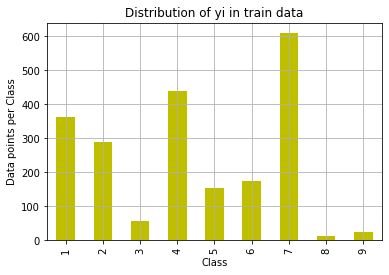

Number of data points in class 7 : 609
Number of data points in class 4 : 439
Number of data points in class 1 : 363
Number of data points in class 2 : 289
Number of data points in class 6 : 176
Number of data points in class 5 : 155
Number of data points in class 3 : 57
Number of data points in class 9 : 24
Number of data points in class 8 : 12


In [20]:
train_class_distribution.plot(kind='bar', color='y')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i] )


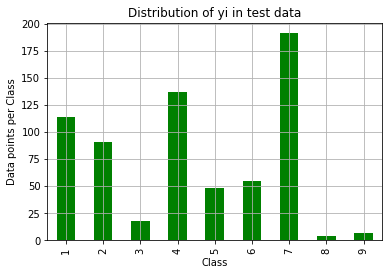

Number of data points in class 7 : 191
Number of data points in class 4 : 137
Number of data points in class 1 : 114
Number of data points in class 2 : 91
Number of data points in class 6 : 55
Number of data points in class 5 : 48
Number of data points in class 3 : 18
Number of data points in class 9 : 7
Number of data points in class 8 : 4


In [21]:
test_class_distribution.plot(kind='bar', color='g')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i] )


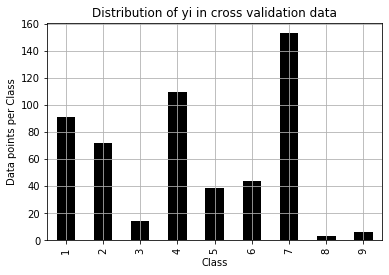

In [22]:
cross_validation_distribution.plot(kind='bar', color='k')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

## Prediction using a 'Random Model'

In [23]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =((((C.T)/C.sum(axis=1))).T)
    B = (C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    print("-"*25, "Confusion matrix", "-"*25)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

# Unvariate Anlaysis

### 3.2.1 Gene

In [24]:
unique_genes = train_df['Gene'].value_counts()
print("Number of unique values: ", unique_genes.shape[0])
print(unique_genes.head())

Number of unique values:  234
BRCA1    171
TP53     102
BRCA2     89
EGFR      82
PTEN      80
Name: Gene, dtype: int64


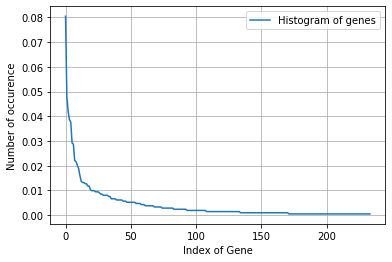

In [25]:
s = sum(unique_genes.values)
h = unique_genes.values/s
plt.plot(h, label = "Histogram of genes")
plt.xlabel("Index of Gene")
plt.ylabel("Number of occurence")
plt.legend()
plt.grid()
plt.show()


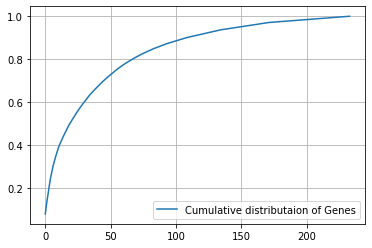

In [26]:
c= np.cumsum(h)
plt.plot(c, label = 'Cumulative distributaion of Genes')
plt.grid()
plt.legend()
plt.show()

In [27]:
# #one hot encoding of gene feature
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [28]:
train_df['Gene'].head()

190      EGFR
2405      NF1
2651    BRCA1
19        CBL
1354     AKT1
Name: Gene, dtype: object

In [29]:
len(gene_vectorizer.get_feature_names())

233

In [30]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", 
                                              train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 233)


## 3.2.2 Univariate Analysis on Variation Feature

In [31]:
unique_variations = train_df['Variation'].value_counts()
print("Number of unique Variation: ", unique_variations.shape[0])

Number of unique Variation:  1927


In [32]:
unique_variations.head()

Truncating Mutations    75
Amplification           43
Deletion                43
Fusions                 17
G12V                     3
Name: Variation, dtype: int64

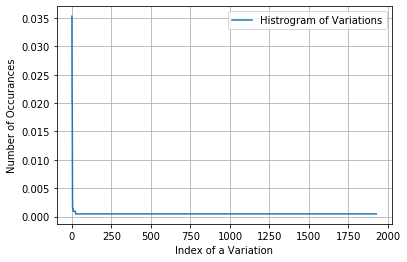

In [33]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.03531073 0.05555556 0.07580038 ... 0.99905838 0.99952919 1.        ]


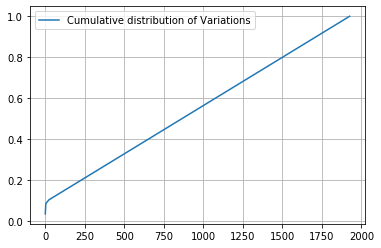

In [34]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [35]:
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [36]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:",
      train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1949)


### Univariate Analysis on Text Feature

In [37]:
import collections
def extract_dictionary_paddle(cls_text):
    dictionary = collections.defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [38]:
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52754


In [39]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [40]:
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [41]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [42]:
print(Counter(sorted_text_occur))

Counter({3: 5147, 4: 3426, 5: 2817, 6: 2646, 7: 2160, 10: 1957, 8: 1848, 9: 1432, 12: 1409, 11: 982, 13: 941, 16: 892, 15: 885, 14: 836, 17: 729, 18: 712, 20: 626, 21: 550, 19: 500, 24: 493, 22: 430, 23: 410, 27: 403, 30: 369, 25: 366, 26: 359, 28: 342, 46: 313, 33: 287, 51: 280, 31: 279, 29: 275, 34: 270, 36: 269, 32: 261, 42: 246, 35: 245, 40: 222, 39: 217, 37: 217, 48: 209, 41: 190, 38: 184, 44: 181, 43: 173, 45: 165, 60: 161, 50: 157, 49: 154, 52: 152, 54: 148, 57: 142, 56: 140, 47: 139, 53: 132, 68: 127, 66: 120, 55: 120, 62: 118, 72: 112, 59: 112, 58: 112, 67: 108, 61: 106, 84: 102, 63: 101, 65: 100, 82: 95, 64: 92, 73: 91, 69: 91, 70: 89, 71: 88, 80: 84, 77: 84, 78: 79, 96: 75, 90: 75, 81: 73, 76: 73, 74: 73, 89: 72, 79: 72, 85: 71, 88: 69, 92: 68, 83: 67, 98: 66, 87: 66, 94: 65, 102: 62, 75: 62, 93: 60, 99: 57, 104: 56, 120: 55, 122: 54, 121: 54, 106: 54, 105: 54, 86: 54, 135: 53, 117: 53, 100: 53, 110: 50, 95: 50, 115: 49, 97: 49, 111: 48, 108: 48, 123: 46, 103: 46, 101: 46, 9

# 4. Machine Learning Models

In [43]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [44]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [45]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [46]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 54936)
(number of data points * number of features) in test data =  (665, 54936)
(number of data points * number of features) in cross validation data = (532, 54936)


# 4.2. K Nearest Neighbour Classification

for alpha = 5
Log Loss : 1.3083149673653565
for alpha = 11
Log Loss : 1.3142526508578958
for alpha = 15
Log Loss : 1.354717357034398
for alpha = 21
Log Loss : 1.4192586453606602
for alpha = 31
Log Loss : 1.464427524521684
for alpha = 41
Log Loss : 1.44458217482702
for alpha = 51
Log Loss : 1.4082373274301336
for alpha = 99
Log Loss : 1.3523705237607713


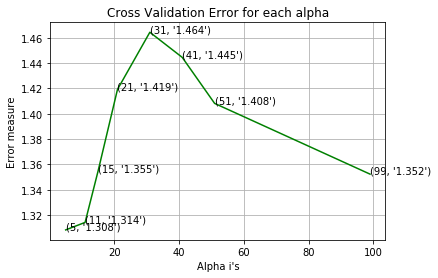

For values of best alpha =  5 The train log loss is: 1.0045665601538396
For values of best alpha =  5 The cross validation log loss is: 1.3083149673653565
For values of best alpha =  5 The test log loss is: 1.3063157084864516


In [47]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",
                      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",
                                          log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",
                                      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.3083149673653565
Number of mis-classified points : 0.44548872180451127
------------------------- Confusion matrix -------------------------


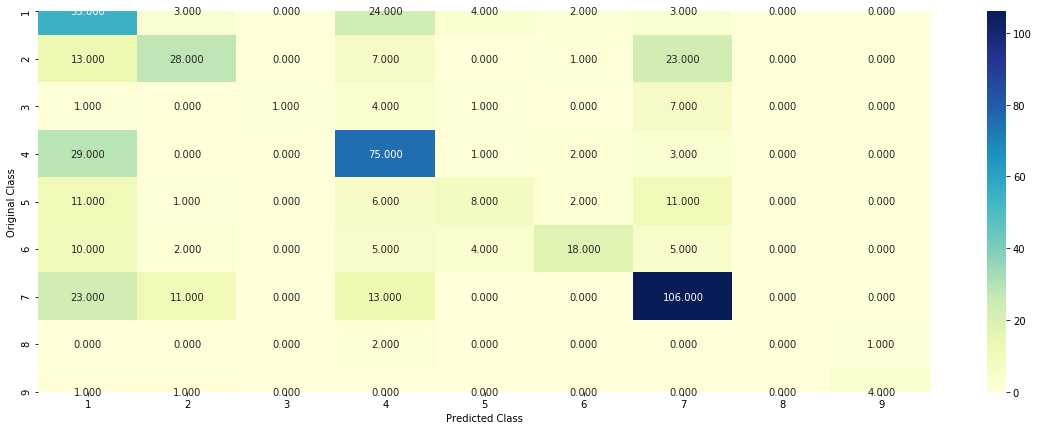

-------------------- Precision matrix (Columm Sum=1) --------------------


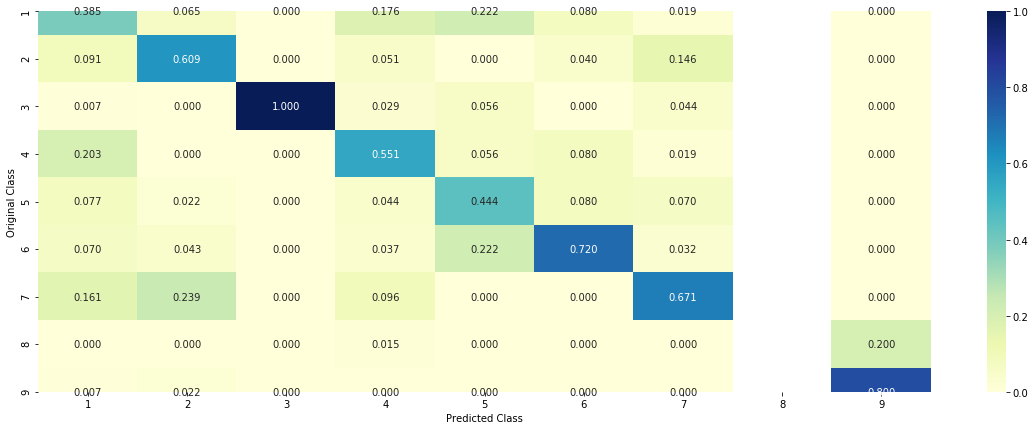

-------------------- Recall matrix (Row sum=1) --------------------


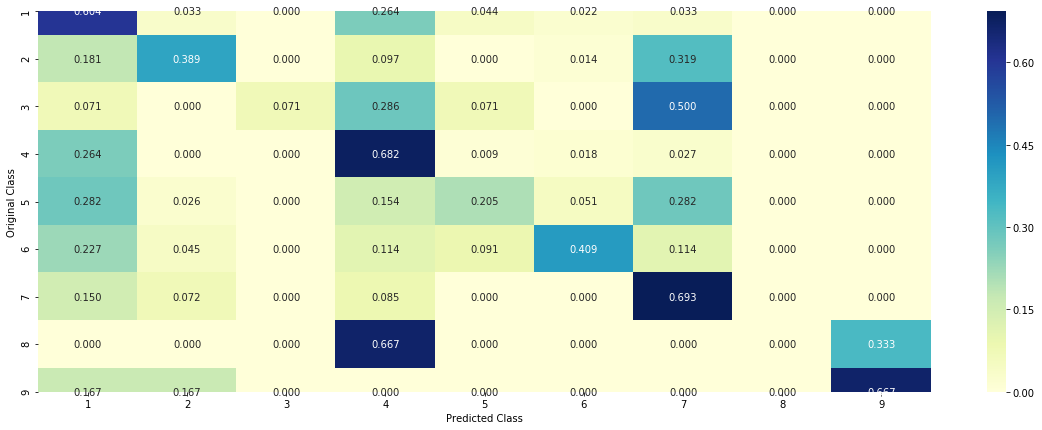

In [48]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [49]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index =100
predicted_cls = sig_clf.predict(test_x_onehotCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_onehotCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 4
The  5  nearest neighbours of the test points belongs to classes [4 4 4 1 4]
Fequency of nearest points : Counter({4: 4, 1: 1})


# logistic regression with balance

for alpha = 1e-06
Log Loss : 1.3309245388121969
for alpha = 1e-05
Log Loss : 1.310972279565729
for alpha = 0.0001
Log Loss : 1.1397671108214595
for alpha = 0.001
Log Loss : 1.1087853433389137
for alpha = 0.01
Log Loss : 1.1810002753367903
for alpha = 0.1
Log Loss : 1.4854155536129379
for alpha = 1
Log Loss : 1.7178088594848153
for alpha = 10
Log Loss : 1.7400575657887531
for alpha = 100
Log Loss : 1.742372327825768


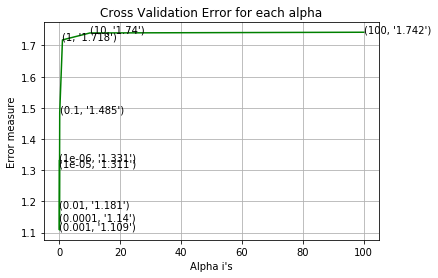

For values of best alpha =  0.001 The train log loss is: 0.540119117541994
For values of best alpha =  0.001 The cross validation log loss is: 1.1087853433389137
For values of best alpha =  0.001 The test log loss is: 1.1314791571058622


In [50]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",
                                      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",
                                              log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",
                      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1087853433389137
Number of mis-classified points : 0.34774436090225563
------------------------- Confusion matrix -------------------------


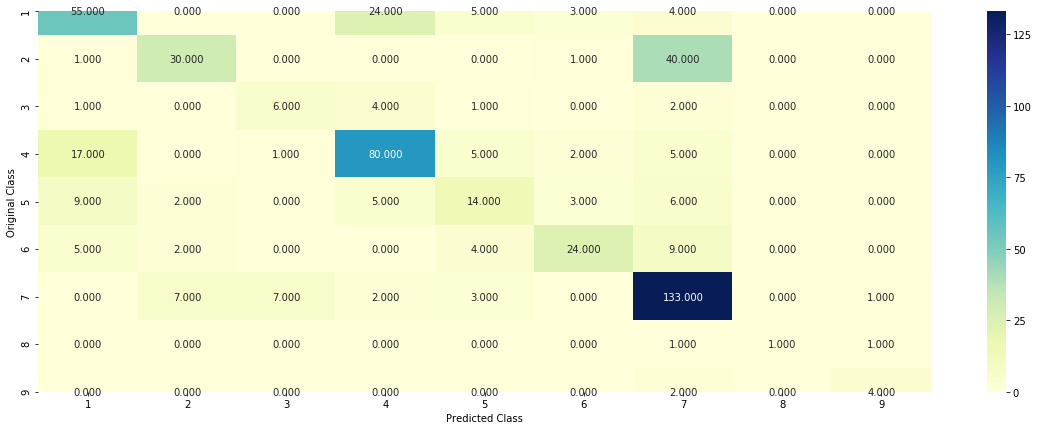

-------------------- Precision matrix (Columm Sum=1) --------------------


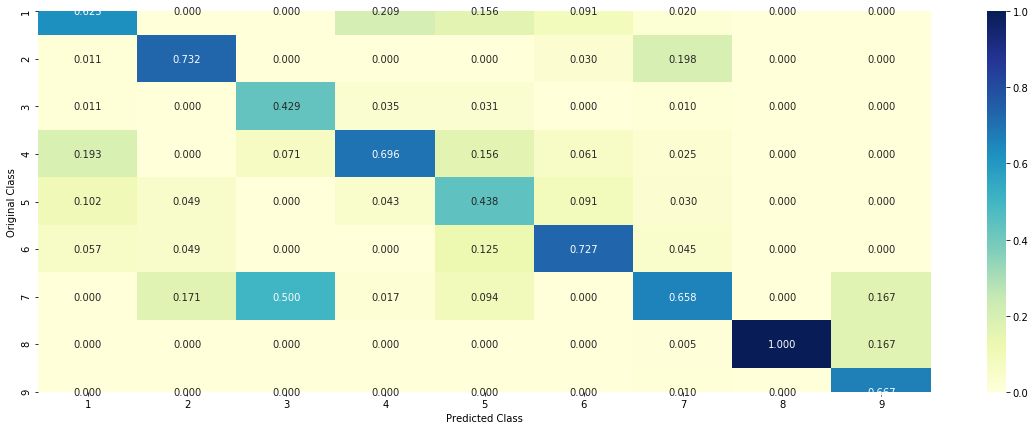

-------------------- Recall matrix (Row sum=1) --------------------


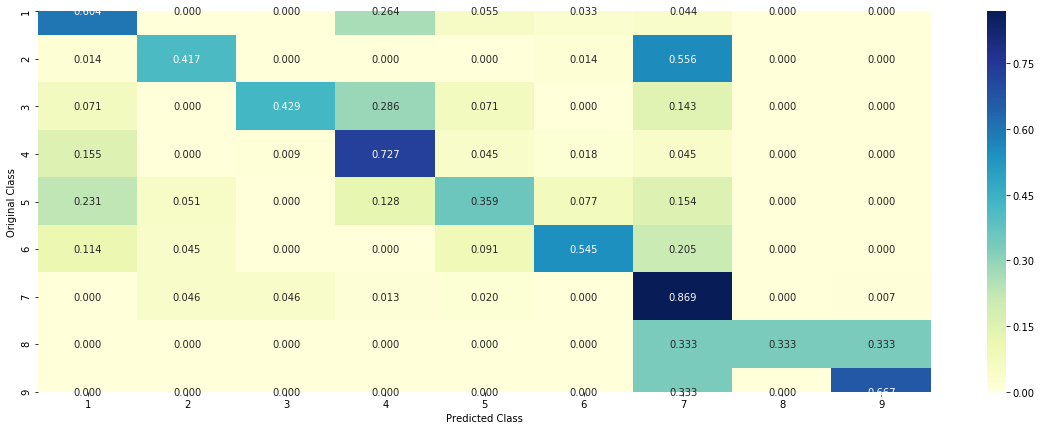

In [51]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)


for C = 1e-05
Log Loss : 1.31472252925573
for C = 0.0001
Log Loss : 1.227036073334715
for C = 0.001
Log Loss : 1.1489656406429498
for C = 0.01
Log Loss : 1.141617123363853
for C = 0.1
Log Loss : 1.380384694975384
for C = 1
Log Loss : 1.7332976164146803
for C = 10
Log Loss : 1.7427500085324608
for C = 100
Log Loss : 1.7427500073283493


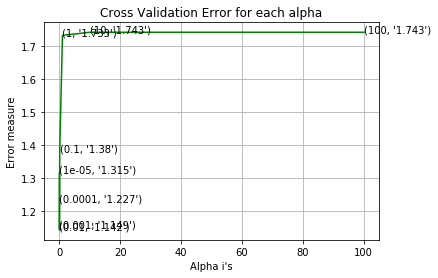

For values of best alpha =  0.01 The train log loss is: 0.7187177621260236
For values of best alpha =  0.01 The cross validation log loss is: 1.141617123363853
For values of best alpha =  0.01 The test log loss is: 1.1635272261196883


In [52]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",
                                      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",
                                              log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",
                                      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.141617123363853
Number of mis-classified points : 0.3609022556390977
------------------------- Confusion matrix -------------------------


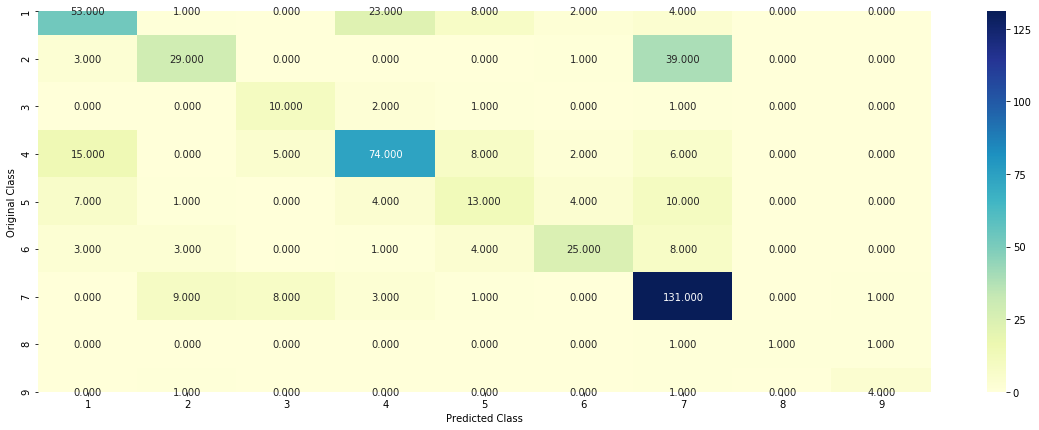

-------------------- Precision matrix (Columm Sum=1) --------------------


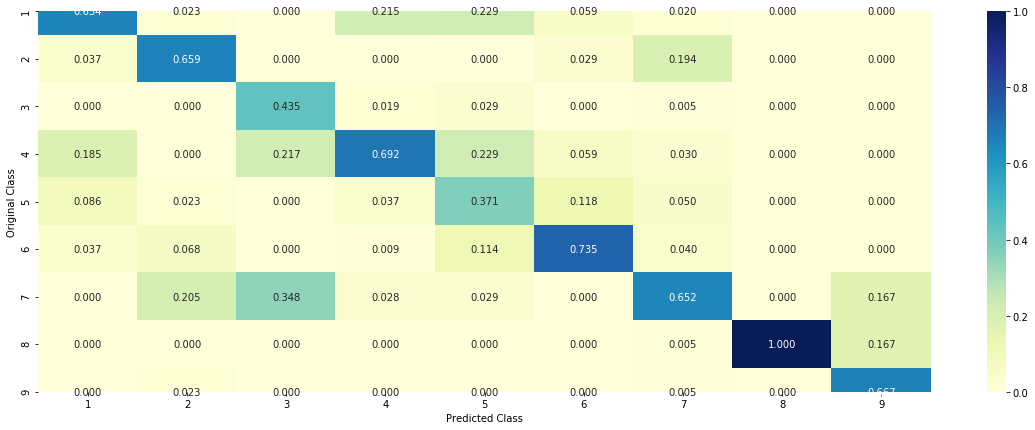

-------------------- Recall matrix (Row sum=1) --------------------


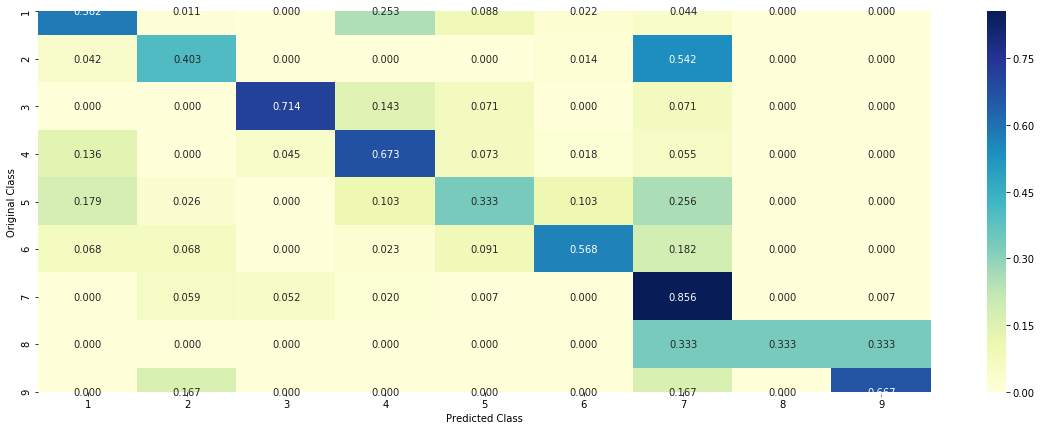

In [53]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [54]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(abs(-clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)

Predicted Class : 7
Predicted Class Probabilities: [[0.0911 0.1069 0.0115 0.1206 0.0655 0.0572 0.5379 0.0057 0.0037]]
Actual Class : 4
--------------------------------------------------


## Stack the model ml extend

In [57]:
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.10
Support vector machines : Log Loss: 1.73
Naive Bayes : Log Loss: 1.29
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.036
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.515
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.119
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.223
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.516


Log loss (train) on the stacking classifier : 0.6224045389496258
Log loss (CV) on the stacking classifier : 1.119286481388508
Log loss (test) on the stacking classifier : 1.1277553684246266
Number of missclassified point : 0.35037593984962406
------------------------- Confusion matrix -------------------------


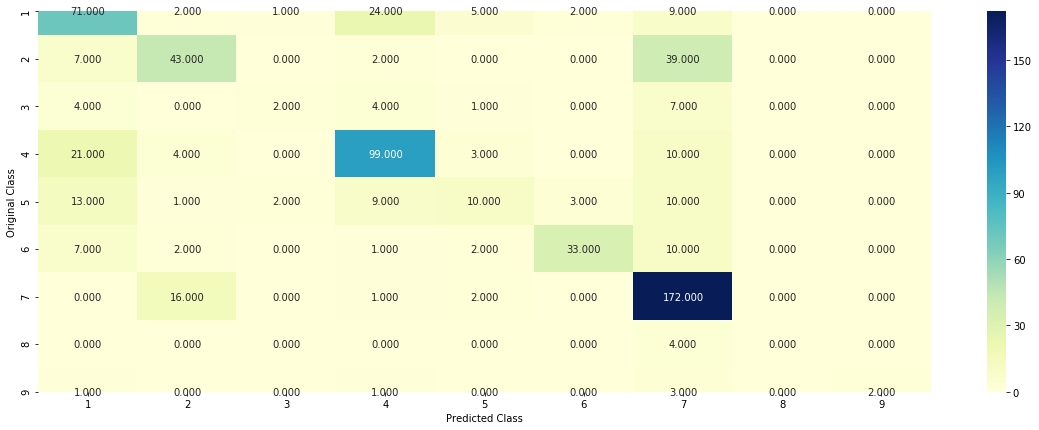

-------------------- Precision matrix (Columm Sum=1) --------------------


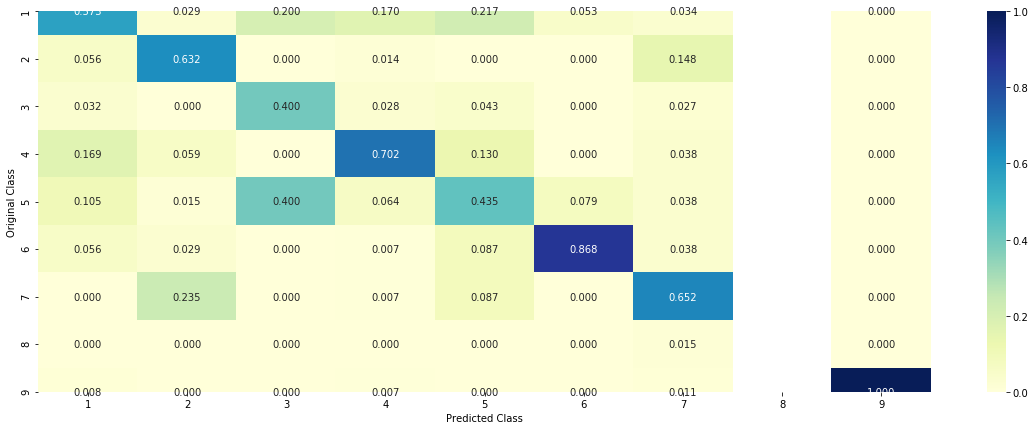

-------------------- Recall matrix (Row sum=1) --------------------


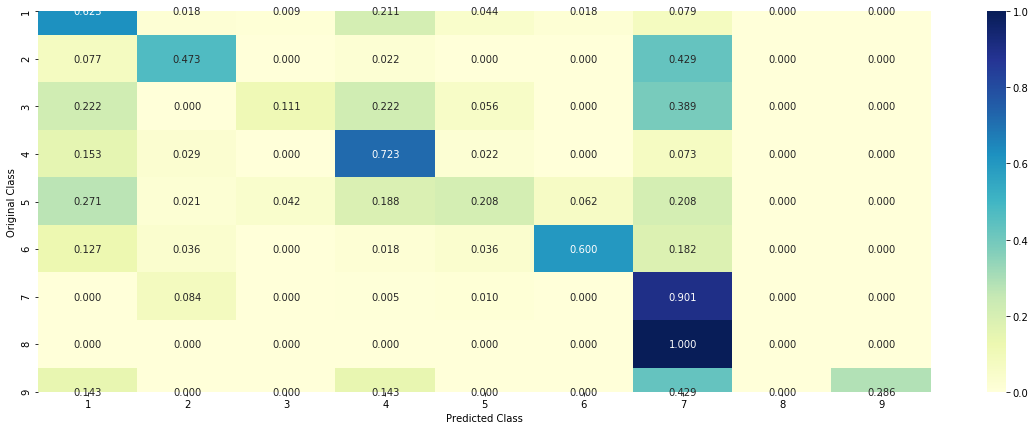

In [58]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))